# [FastAI Framework] Detecting the COVID-19 cases from chest X-ray images 
The machine learning-based model must detect whether the subject of study has been infected or not.

**Data**
This dataset consists of 15264 (512x512) chest X-ray images for the train set and 400 images for the test set. The dataset contains positive and negative classes to indicate the positive and negative COVID-19 cases. You can find some examples of this dataset below:

***

# Initialize

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install fastai --upgrade

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import trange
import os

### Modeling
from sklearn.model_selection import train_test_split
from fastai.vision.all import *

PATH = '/content/drive/MyDrive/DL_Project_2021'

# Setting up the process

In [ ]:
label_df=pd.read_csv(PATH+'/train_labels.csv')
test_df=pd.read_csv(PATH+'/sample_submission.csv')

### Splitting the data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(label_df.File, label_df.Label
                                                    , test_size=0.35, random_state=42, stratify=label_df.Label)
train_df = pd.DataFrame(X_train)
train_df['Label'] = y_train
train_df['is_valid'] = False

valid_df = pd.DataFrame(X_test)
valid_df['Label'] = y_test
valid_df['is_valid'] = True

### Combine train / valid with `is_valid` indicator to pass to the DataBlock.dataloaders()
train_valid_df = pd.concat([train_df, valid_df])
train_valid_df.columns = ['fname','labels', 'is_valid']
train_valid_df.index = range(len(train_valid_df)) # re-index

### Overview of the data size
print ('Test size: ', len(test_df))
train_valid_df.groupby(['is_valid','labels']).count()

Test size:  400


fname
is_valid labels       
False    0        8901
         1        1020
True     0        4793
         1         550

# Building a datablock and dataloaders

[0, 1]


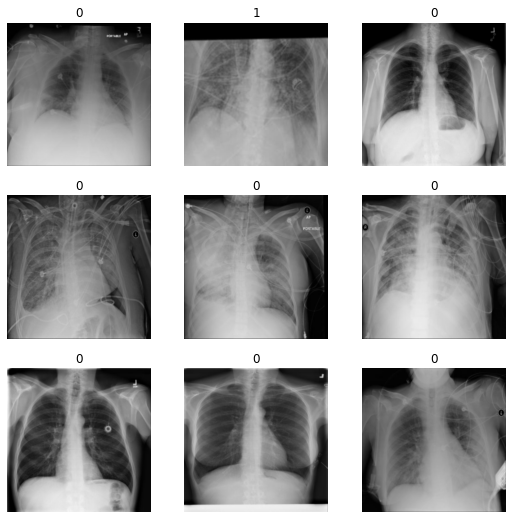

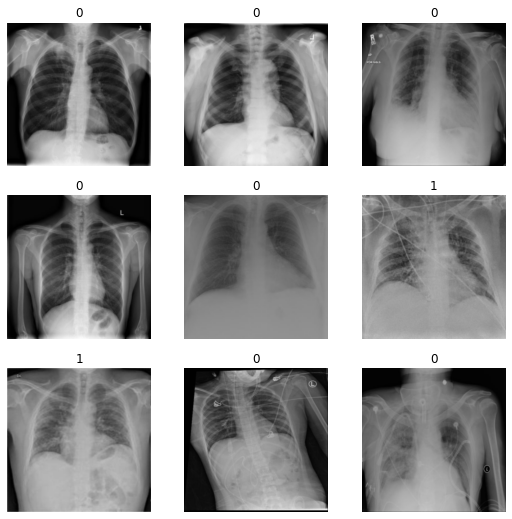

In [ ]:
### Setting up the path
path = Path(PATH)
path_train = path/'train'
fnames = get_image_files(path_train)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock)
                   , get_x = ColReader(0, pref=path_train) 
                   , get_y = ColReader(1)
                   , splitter=ColSplitter()
                   , item_tfbms = Resize(256)
                   ) 

### DataBlock ==> Datasets or DataLoaders
dls = dblock.dataloaders(train_valid_df)
dls.show_batch()
print (dls.vocab)
dls.show_batch()

# dblock.summary(path/"train/train")

Alternative way to setup the datablock:
  - passing the file's path instead of the dataframe 
  - the label values are retrieved via function
  - random split (train, test)

```python
def label_func(file_name):
    pic_name = os.path.basename(file_name)
    return str(label_df[label_df.clean_name == pic_name].Label.values[0])

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock)
                   , get_items = get_image_files 
                   , get_y = label_func  
                   , splitter=RandomSplitter(valid_pct=0.3, seed=42)
                   , item_tfms = Resize(224)
                   ) 
dls = dblock.dataloaders(path/"train")
```

***

# Training the Model

1. Fine Tuning `fine_tune`
  - Trains the randomly added layers for one epoch, with all other layers frozen
  - Unfreezes all of the layers, and trains them all for the number of epochs requested


2. Configure the weight decay (true_wd) and weight decay in batch norm layer (bn_wd): https://forums.fast.ai/t/training-loss-validation-loss/39698/9

  ```
  learn = create_cnn(data_bunch, models.resnet34, ps=0, true_wd = False, bn_wd = False)
  lr = 5e-2
  learn.fit_one_cycle(50, slice(lr), wd=0)
  ```

3. Learning Rate
  - As a general rule, we want to be 10x back from the minimum point, regardless of slope.

In [ ]:
# Use macro-averaging to weight your metric towards the smallest one
# F1 'macro' - the macro weighs each class equally
f1_score_macro = F1Score(average="macro")
f1_score_micro = F1Score(average="micro")

### Model 1: Densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Minimum/10: 1.45e-02, steepest point: 8.32e-06


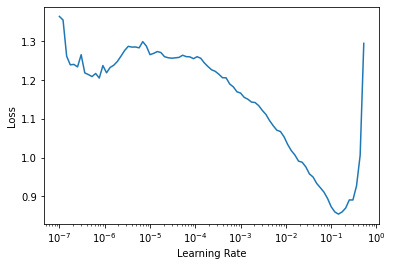

In [ ]:
learn_densenet121 = cnn_learner(dls,  models.densenet121
                                , metrics=[accuracy, error_rate, f1_score_macro, f1_score_micro])
lr_min,lr_steep = learn_densenet121.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,f1_score,time
0,0.251538,0.127781,0.965188,0.034812,0.904521,0.965188,01:38


epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,f1_score,time
0,0.087804,0.067270,0.977915,0.022085,0.937368,0.977915,01:59
1,0.068777,0.094260,0.975856,0.024144,0.937578,0.975856,01:58
2,0.070160,0.134981,0.962006,0.037994,0.902509,0.962006,01:58
3,0.049381,0.091893,0.974733,0.025267,0.934176,0.974733,01:58
4,0.042633,0.056118,0.983717,0.016283,0.956023,0.983717,01:58
5,0.021529,0.058729,0.985214,0.014786,0.959612,0.985214,01:57
6,0.014480,0.066089,0.985401,0.014599,0.960541,0.985401,01:58
7,0.005834,0.055817,0.987647,0.012353,0.966718,0.987647,01:58
8,0.001615,0.059900,0.987647,0.012353,0.966395,0.987647,01:58
9,0.000970,0.062362,0.987460,0.012540,0.966241,0.987460,01:58


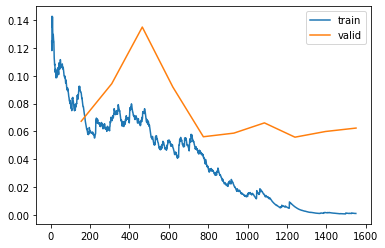

In [ ]:
learn_densenet121.fine_tune(10, base_lr=1e-2)
learn_densenet121.recorder.plot_loss()

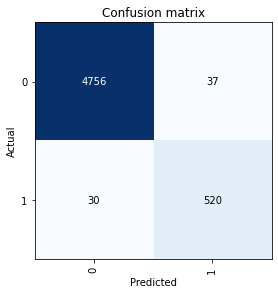

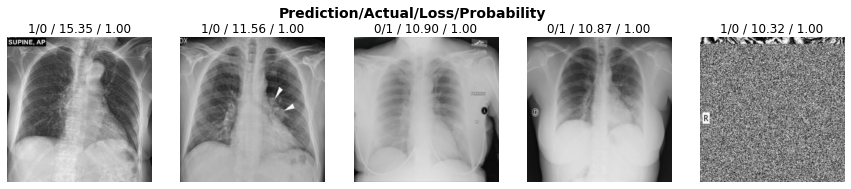

In [ ]:
### Analyze Result: Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn_densenet121)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

### Model2: Resnet50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Minimum/10: 4.79e-02, steepest point: 1.45e-02


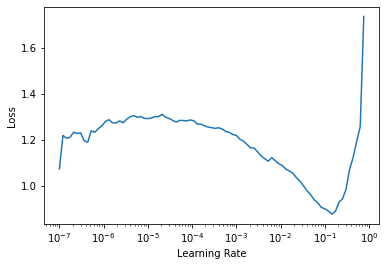

In [ ]:
learn_resnet50 = cnn_learner(dls,  models.resnet50
                                , metrics=[accuracy, error_rate, f1_score_macro, f1_score_micro])
lr_steep, lr_min = learn_resnet50.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,time
0,0.237815,0.138354,0.960322,0.039678,0.896234,13:26


epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,time
0,0.102318,0.067010,0.979038,0.020962,0.943249,01:41
1,0.079954,0.102153,0.970803,0.029197,0.917339,01:41
2,0.077626,0.099408,0.977354,0.022646,0.937529,01:40
3,0.059665,0.085310,0.977166,0.022834,0.939350,01:40
4,0.051090,0.056331,0.981845,0.018155,0.950329,01:40
5,0.026138,0.052192,0.983530,0.016470,0.955410,01:40
6,0.014496,0.061221,0.986712,0.013288,0.964897,01:40
7,0.004567,0.066113,0.986337,0.013663,0.962311,01:40
8,0.002061,0.066580,0.987273,0.012727,0.965655,01:40
9,0.000515,0.068458,0.986899,0.013101,0.964008,01:40


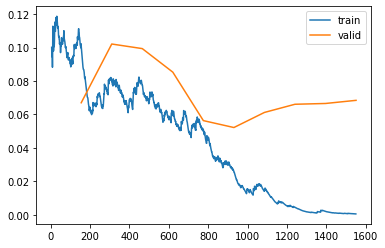

In [ ]:
# learn_resnet50.fine_tune(10, base_lr=1e-2, callbacks=[ShowGraph(learn), EarlyStoppingCallback(monitor='f1_score_multi', min_delta=0.1, patience=2)])
learn_resnet50.fine_tune(10, base_lr=1e-2)
learn_resnet50.recorder.plot_loss()

### Model3: VGG

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Minimum/10: 1.74e-02, steepest point: 2.75e-06


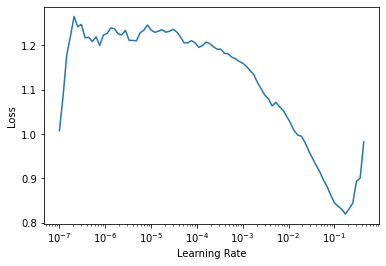

In [ ]:
learn_vgg = cnn_learner(dls,  models.vgg19_bn
                                , metrics=[accuracy, error_rate, f1_score_macro, f1_score_micro])
lr_min,lr_steep = learn_vgg.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,time
0,0.255580,0.142957,0.962755,0.037245,0.887286,02:05


epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,time
0,0.085476,0.075472,0.971739,0.028261,0.915721,02:38
1,0.073495,0.071774,0.980535,0.019465,0.945814,02:37
2,0.073943,0.119860,0.964814,0.035186,0.912896,02:38
3,0.072599,0.093454,0.979038,0.020962,0.941352,02:37
4,0.061788,0.089484,0.977354,0.022646,0.935610,02:37
5,0.029521,0.073073,0.980535,0.019465,0.944418,02:37
6,0.025181,0.061105,0.981097,0.018903,0.946253,02:37
7,0.007904,0.086615,0.978477,0.021523,0.937182,02:38
8,0.003151,0.058800,0.985589,0.014411,0.960826,02:37
9,0.000933,0.057840,0.986337,0.013663,0.962801,02:37


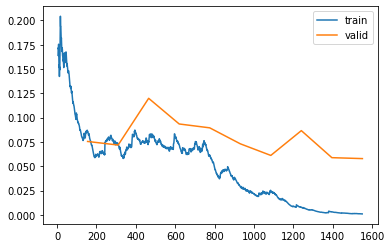

In [ ]:
learn_vgg.fine_tune(10, base_lr=1e-2)
learn_vgg.recorder.plot_loss()

### Model4: Alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Minimum/10: 1.58e-02, steepest point: 2.51e-02


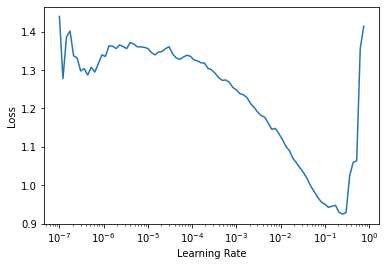

In [ ]:
learn_alexnet = cnn_learner(dls,  models.alexnet
                                , metrics=[accuracy, error_rate, f1_score_macro, f1_score_micro])
lr_steep, lr_min = learn_alexnet.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,f1_score,time
0,0.058649,0.119000,0.980535,0.019465,0.947047,0.980535,01:02


epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,f1_score,time
0,0.054357,0.174311,0.958263,0.041737,0.893700,0.958263,01:03
1,0.072616,0.086458,0.978102,0.021898,0.940572,0.978102,01:03
2,0.055318,0.080449,0.975856,0.024144,0.932620,0.975856,01:03
3,0.020788,0.069371,0.983530,0.016470,0.956253,0.983530,01:02
4,0.010038,0.069200,0.983904,0.016096,0.956633,0.983904,01:02


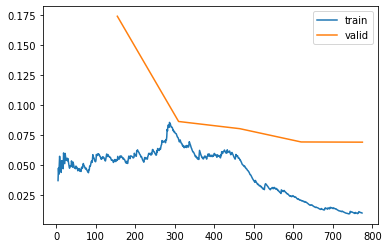

In [ ]:
learn_alexnet.fine_tune(5, base_lr=1e-2)
learn_alexnet.recorder.plot_loss()

***

### Saving the model

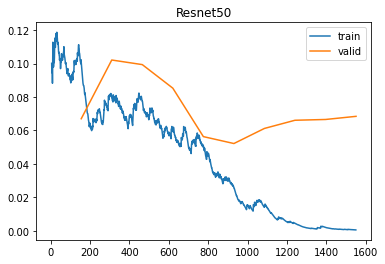

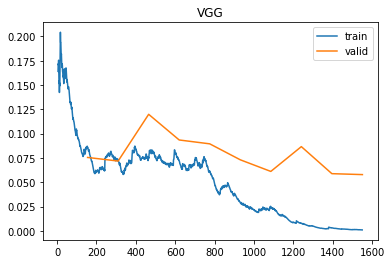

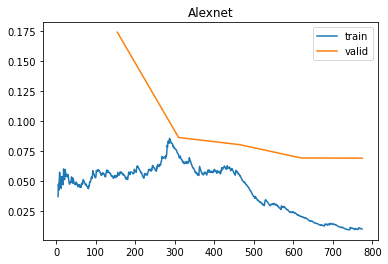

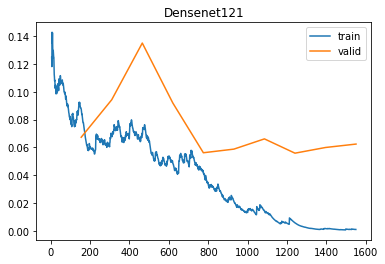

In [ ]:
learn_resnet50.recorder.plot_loss()
plt.title("Resnet50"); plt.show()
learn_vgg.recorder.plot_loss()
plt.title("VGG"); plt.show()
learn_alexnet.recorder.plot_loss()
plt.title("Alexnet"); plt.show()
learn_densenet121.recorder.plot_loss()
plt.title("Densenet121"); plt.show()

In [ ]:
pickle.dump(learn_resnet50, open(PATH+'/model/fastai.resnet50.obj','wb'))
pickle.dump(learn_vgg, open(PATH+'/model/fastai.vgg.obj','wb'))
pickle.dump(learn_alexnet, open(PATH+'/model/fastai.alexnet.obj','wb'))
pickle.dump(learn_densenet121, open(PATH+'/model/fastai.densenet.obj','wb'))

In [ ]:
# learn_resnet50 = pickle.load(open(PATH+'/model/fastai.resnet50.obj','rb'))
# learn_vgg = pickle.load(open(PATH+'/model/fastai.vgg.obj','rb'))
# learn_alexnet = pickle.load(open(PATH+'/model/fastai.alexnet.obj','rb'))
# learn_densenet121 = pickle.load(open(PATH+'/model/fastai.densenet.obj','rb'))

***

# Prediction

In [ ]:
path_test = path/'test'
test_file = get_image_files(path_test)

### Prediction
test_file_name = []
result_resnet = []
result_vgg = []
result_alexnet = []
result_densenet = []

for name in test_file:

  result_resnet.append(learn_resnet50.predict(name))
  result_vgg.append(learn_vgg.predict(name))
  result_alexnet.append(learn_alexnet.predict(name))
  result_densenet.append(learn_densenet121.predict(name))
  test_file_name.append(name)


### Result DataFrame
test_result_df = pd.DataFrame({"vgg": [x[0] for x in result_vgg]
                              ,"vgg_prob_1": [float(x[2][1]) for x in result_vgg]
                              ,"vgg_prob_0": [float(x[2][0]) for x in result_vgg]
                               
                              ,"alexnet": [x[0] for x in result_alexnet]
                              ,"alexnet_prob_1": [float(x[2][1]) for x in result_alexnet]
                              ,"alexnet_prob_0": [float(x[2][0]) for x in result_alexnet] 
                               
                              ,"res50": [x[0] for x in result_resnet]
                              ,"res50_prob_1": [float(x[2][1]) for x in result_resnet]
                              ,"res50_prob_0": [float(x[2][0]) for x in result_resnet] 
                               
                              ,"densenet": [x[0] for x in result_densenet]
                              ,"densenet_prob_1": [float(x[2][1]) for x in result_densenet]
                              ,"densenet_prob_0": [float(x[2][0]) for x in result_densenet] 
                                
                              ,"file_name": [os.path.basename(x) for x in test_file_name]}
                            , index=range(len(test_file_name)))
def is_all_equal(x):
  if (x.vgg == x.alexnet) and (x.vgg == x.res50) and (x.vgg == x.densenet): return "Y"
  else: return "N"
  
test_result_df['is_equal'] = test_result_df.apply(lambda x: is_all_equal(x), axis=1)
test_result_df['combine_prob'] = test_result_df[['vgg_prob_1','alexnet_prob_1','res50_prob_1','densenet_prob_1']].mean(axis=1)
test_result_df['combine_class'] = test_result_df.apply(lambda x: 1 if x.combine_prob >= 0.5 else 0, axis=1)

In [ ]:
test_result_df.groupby(['is_equal','combine_class','densenet']).count()['vgg'].reset_index()

,is_equal,combine_class,densenet,vgg
0,N,0,0,3
1,N,0,1,4
2,N,1,0,2
3,N,1,1,8
4,Y,0,0,204
5,Y,1,1,179


In [ ]:
test_result_df.to_csv(PATH+'/submission_file/submission_fai_vgg_alexnet_resnet_densenet.csv', index=False)

for model in ['vgg','alexnet','res50','densenet','combine_class']:
  temp_df = test_result_df[['file_name',model]]
  temp_df.columns = ['File','Label']
  temp_df.to_csv(PATH+'/submission_file/submission_fai_' + model + '.csv', index=False)